In [1]:
%run data_loader.ipynb

white wine columns Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
read wine None
<class 'pandas.core.frame.Data

In [8]:
features = wines.iloc[:,:-3]
class_labels = np.array(wines['quality_label'])
label_names = ['low', 'medium', 'high']
feature_names = list(features.columns)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, class_labels, test_size=0.3, 
                                                    random_state=42)

In [13]:
from collections import Counter
print(Counter(y_train), Counter(y_test))
print('Features', feature_names)

Counter({'medium': 2737, 'low': 1666, 'high': 144}) Counter({'medium': 1178, 'low': 718, 'high': 54})
Features ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## Feature Scaling

In [15]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(X_train)
SX_train = ss.transform(X_train)
SX_test = ss.transform(X_test)

## Train

In [20]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(SX_train, y_train)
dt_predictions = dt.predict(SX_test)

In [21]:
%run evaluation.ipynb
display_model_performance_metrics(true_labels=y_test, predicted_labels=dt_predictions, classes=label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7195
Precision: 0.721
Recall: 0.7195
F1 Score: 0.7202

Model Classification report:
------------------------------
labels ['low', 'medium', 'high']
             precision    recall  f1-score   support

        low       0.68      0.66      0.67       718
     medium       0.77      0.77      0.77      1178
       high       0.26      0.30      0.28        54

avg / total       0.72      0.72      0.72      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           477    237    4
        medium        226    910   42
        high            2     36   16


In [25]:
dt_feature_importances = dt.feature_importances_
dt_feature_names, dt_feature_scores = zip(*sorted(
    zip(feature_names, dt_feature_importances), key=lambda x: x[1]))

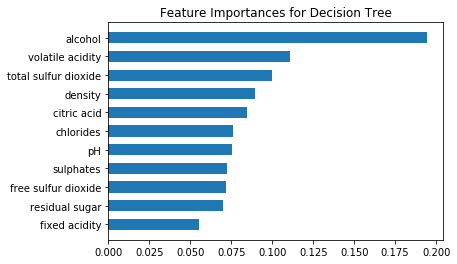

In [38]:
y_position = list(range(len(dt_feature_names)))
plt.barh(y_position, dt_feature_scores, height=0.6, align='center')
plt.yticks(y_position, dt_feature_names)
plt.xlabel=('Relative Importance Score')
plt.ylabel=('Feature')
t = plt.title('Feature Importances for Decision Tree')

In [43]:
from graphviz import Source
from sklearn import tree
from IPython.display import Image
graph = Source(tree.export_graphviz(dt, out_file=None, class_names=label_names,
                                   filled=True, rounded=True, special_characters=False,
                                   feature_names= feature_names, max_depth=3))
png_data=graph.pipe(format='png')

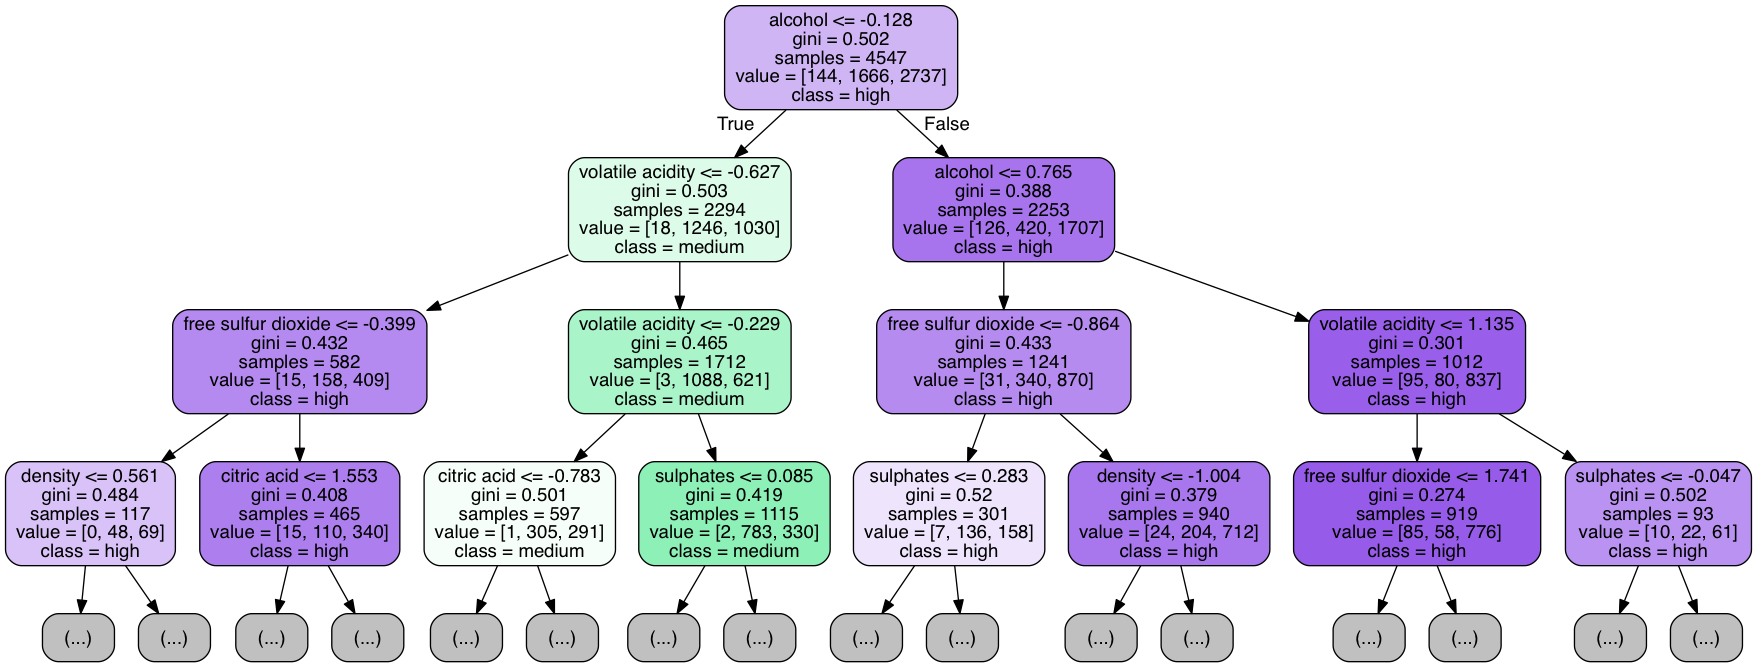

In [45]:
with open('dtree_structure.png','wb') as f:
    f.write(png_data)
Image(png_data)

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(SX_train, y_train)
rf_predictions = rf.predict(SX_test)

In [49]:
display_model_performance_metrics(true_labels=y_test, predicted_labels=rf_predictions,
                                  classes=label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7821
Precision: 0.779
Recall: 0.7821
F1 Score: 0.7782

Model Classification report:
------------------------------
labels ['low', 'medium', 'high']
             precision    recall  f1-score   support

        low       0.74      0.73      0.74       718
     medium       0.81      0.84      0.82      1178
       high       0.64      0.26      0.37        54

avg / total       0.78      0.78      0.78      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           526    191    1
        medium        186    985    7
        high            1     39   14


## Hyper parameters Tuning

In [50]:
print(rf.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [52]:
from sklearn.model_selection import GridSearchCV

In [53]:
param_grid = {'n_estimators': [100, 200, 300, 500],
              'max_features': ['auto', None, 'log2']}

In [55]:
clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, 
                   scoring='accuracy')
clf.fit(SX_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300, 500], 'max_features': ['auto', None, 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [59]:
print(clf.best_params_)

{'max_features': 'auto', 'n_estimators': 200}


In [60]:
results=clf.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'],
                                       results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'max_features': 'auto', 'n_estimators': 100} 0.7928 0.0119
{'max_features': 'auto', 'n_estimators': 200} 0.7955 0.0101
{'max_features': 'auto', 'n_estimators': 300} 0.7941 0.0086
{'max_features': 'auto', 'n_estimators': 500} 0.795 0.0094
{'max_features': None, 'n_estimators': 100} 0.7847 0.0144
{'max_features': None, 'n_estimators': 200} 0.781 0.0149
{'max_features': None, 'n_estimators': 300} 0.784 0.0128
{'max_features': None, 'n_estimators': 500} 0.7858 0.0107
{'max_features': 'log2', 'n_estimators': 100} 0.7928 0.0119
{'max_features': 'log2', 'n_estimators': 200} 0.7955 0.0101
{'max_features': 'log2', 'n_estimators': 300} 0.7941 0.0086
{'max_features': 'log2', 'n_estimators': 500} 0.795 0.0094


In [68]:
rf = RandomForestClassifier(n_estimators=200, max_features='auto', random_state=42)
rf.fit(SX_train, y_train)
rf_predictions = rf.predict(SX_test)
display_model_performance_metrics(true_labels=y_test, predicted_labels=rf_predictions, classes=label_names)


Model Performance metrics:
------------------------------
Accuracy: 0.8108
Precision: 0.8114
Recall: 0.8108
F1 Score: 0.8053

Model Classification report:
------------------------------
labels ['low', 'medium', 'high']
             precision    recall  f1-score   support

        low       0.80      0.73      0.76       718
     medium       0.82      0.89      0.85      1178
       high       0.88      0.28      0.42        54

avg / total       0.81      0.81      0.81      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           522    196    0
        medium        132   1044    2
        high            0     39   15


## Feature Importances

In [70]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
interpreter = Interpretation(SX_test, feature_names=feature_names)
im_model = InMemoryModel(rf.predict_proba, examples=SX_train,
                                     target_names=rf.classes_)

In [73]:
rf_feature_importances = rf.feature_importances_
rf_feature_names, rf_feature_scores = zip(*sorted(zip(feature_names,
                                           rf_feature_importances), key=lambda x: x[1]))

[11/11] features ████████████████████ Time elapsed: 0 seconds

Text(0,0.5,'Feature')

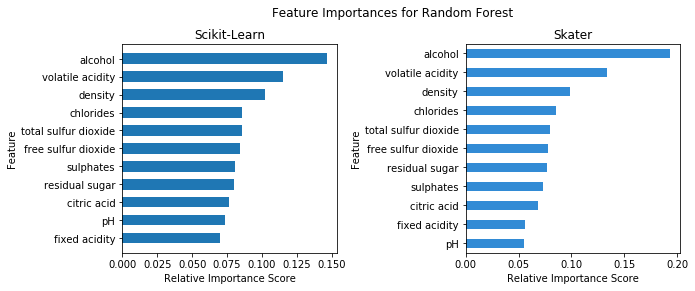

In [91]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Feature Importances for Random Forest', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.6)
y_position = list(range(len(rf_feature_names)))
ax1.barh(y_position, rf_feature_scores, height=0.6, align='center',
                 tick_label=rf_feature_names)
ax1.set_title('Scikit-Learn')
ax1.set_xlabel('Relative Importance Score')
ax1.set_ylabel('Feature')
plots = interpreter.feature_importance.plot_feature_importance(im_model, 
                                                               ascending=False, ax=ax2)
ax2.set_title("Skater")
ax2.set_xlabel('Relative Importance Score')
ax2.set_ylabel('Feature')

classes 0
classes 1
classes 2


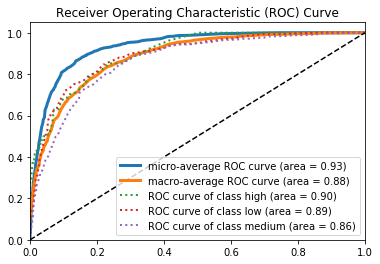

In [100]:
%run evaluation.ipynb
plot_model_roc_curve(rf, SX_test, y_test)

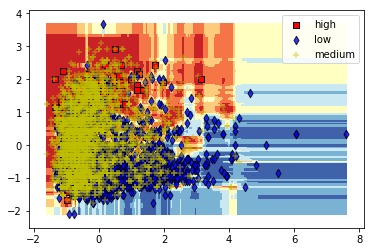

In [102]:
feature_indices = [i for i, feature in enumerate(feature_names) 
                       if feature in ['alcohol', 'volatile acidity']]
plot_model_decision_surface(clf=rf, train_features=SX_train[:, feature_indices], 
                      train_labels=y_train, plot_step=0.02, cmap=plt.cm.RdYlBu,
                      markers=[',', 'd', '+'], alphas=[1.0, 0.8, 0.5], colors=['r', 'b', 'y'])



## Intepreting Model Prediction

In [104]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
exp = LimeTabularExplainer(SX_train, feature_names=feature_names,
                           discretize_continuous=True,
                           class_names=rf.classes_)

In [108]:
exp.explain_instance(SX_test[10], rf.predict_proba, top_labels=1).show_in_notebook()

In [110]:
exp.explain_instance(SX_test[747], rf.predict_proba, top_labels=1).show_in_notebook()

## Partial Dependence

[81/81] grid cells ████████████████████ Time elapsed: 4 seconds

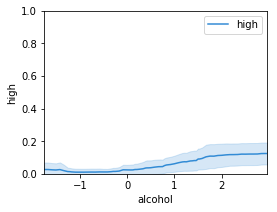

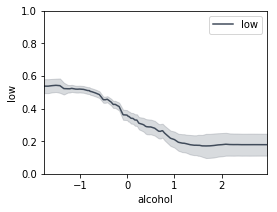

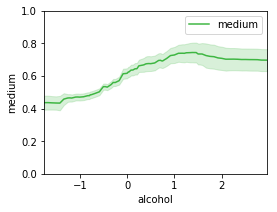

In [117]:
axes_list = interpreter.partial_dependence.plot_partial_dependence(['alcohol'], 
                     im_model, grid_resolution=100, with_variance=True, figsize = (4, 3))
axs = axes_list[0][3:]
[ax.set_ylim(0, 1) for ax in axs];

[4698/4698] grid cells ████████████████████ Time elapsed: 48 seconds

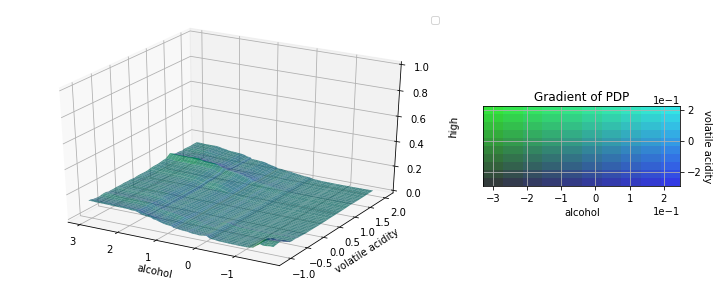

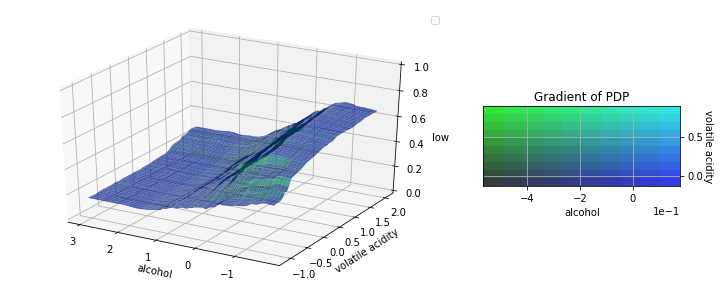

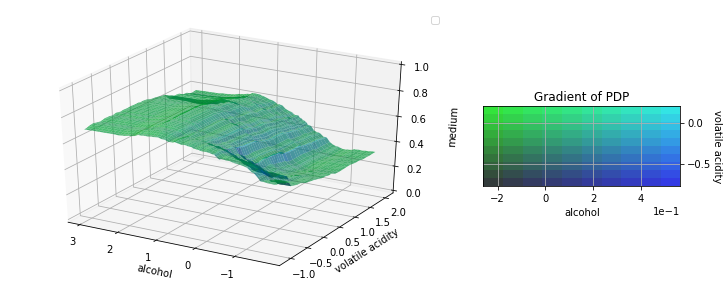

In [115]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('alcohol', 'volatile acidity')], 
                                                                    im_model, n_samples=1000, figsize=(12, 5),
                                                                    grid_resolution=100)
axs = plots_list[0][3:]
[ax.set_zlim(0, 1) for ax in axs];